Number of instances = 131724
Number of attributes = 6
Number of duplicate rows = 5939
Number of rows before discarding duplicates = 129933
Number of rows after discarding duplicates = 123994
Number of instances = 175200
Number of attributes = 6
Training set mean = 47
Training set standard deviation = 54
Test set mean = 48
Test set standard deviation = 54


Text(0.5, 1.0, 'Daily Air Quality (variance = 2943.2929)')

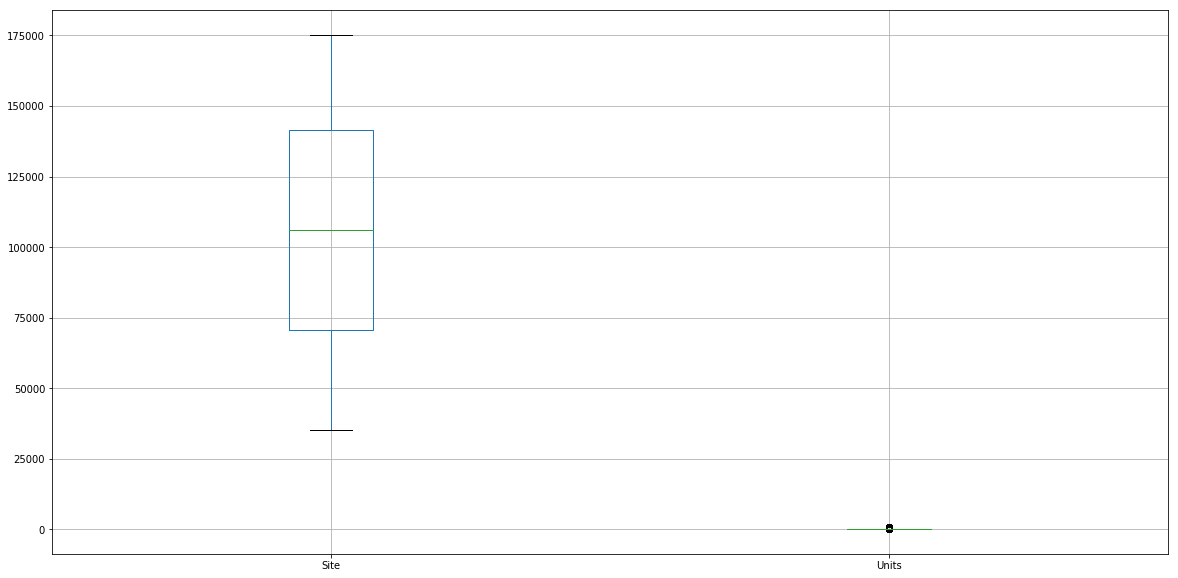

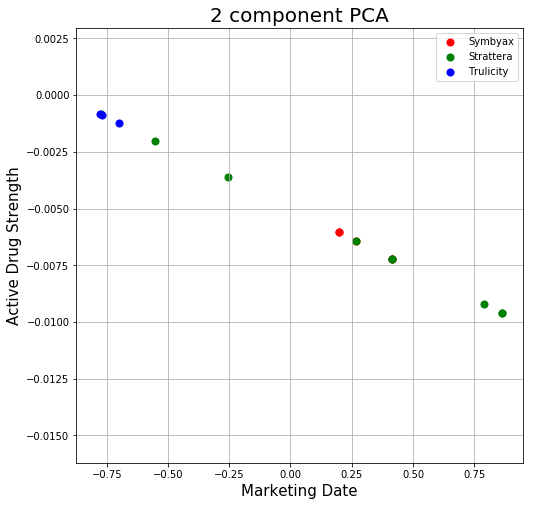

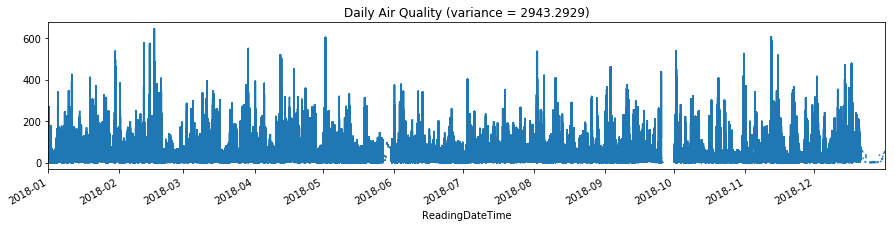

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tkinter as tk
from tkinter import filedialog
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

global data


#---READ DATA FILES---
path = "./DataSet/"

filename_read = os.path.join(path,"product.csv")
df_drugs = pd.read_csv(filename_read,na_values=['NA','?'])

filename_read = os.path.join(path,"LaqnData.csv")
df_air = pd.read_csv(filename_read,na_values=['NA','?'])

filename_read = os.path.join(path,"product2.csv")
df_air2 = pd.read_csv(filename_read,na_values=['NA','?'])




#---MISSING VALUES---
data = df_air2
outpath = os.path.join(path,"out.csv")
data.columns = ['Site', 'Species', 'ReadingDateTime', 'Value', 'Units', 'Provisional or Ratified']

print('Number of instances = %d' %(data.shape[0]))
print('Number of attributes = %d' %(data.shape[1]))
data=data.drop(['Provisional or Ratified'], axis=1)

#dropping all rows that contain missing values
data = data.dropna(axis='rows')


#data.head()

#writing modified data frame to csv file
data.to_csv(outpath)
#resulting file has no missing value rows


#---OUTLIERS---
%matplotlib inline
# data2 = data.drop(['Class'],axis=1)
data.boxplot(figsize=(20,10))


#---DUPLICATE DATA---
df = df_drugs
df.drop(['PRODUCTID', 'PRODUCTNDC'], axis=1, inplace=True)
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print('Number of rows before discarding duplicates = %d' % (df.shape[0]))
data2 = df.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data2.shape[0]))


#---SHUFFLING DATA---
df = df_drugs
np.random.seed(38) #uncomment this line to get the same shuffle each time

df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)
# use inplace=False
df


#---SORTING DATAFRAMES---
df = df_drugs

df = df.sort_values(by='PROPRIETARYNAME', ascending=True, axis=0)
df


#---SAVING A DATA FRAME---
data = df_air
exportPath = os.path.join(path,"no_missing_val.csv")
data.columns = ['Site', 'Species', 'ReadingDateTime', 'Value', 'Units', 'Provisional or Ratified']

print('Number of instances = %d' %(data.shape[0]))
print('Number of attributes = %d' %(data.shape[1]))
data=data.drop(['Provisional or Ratified'], axis=1)

#dropping all rows that contain missing values
data = data.dropna(axis='rows')

#saving
data.to_csv(exportPath, index = None, header=True)



#---DROPPING FIELDS---
df = df_drugs

df.drop(axis=1, index=[3], columns=['ROUTENAME', 'PROPRIETARYNAMESUFFIX'], inplace=True)
df[0:5]



#---CALCULATED FIELDS---
df = df_drugs
df['ACTIVE_NUMERATOR_STRENGTH'] = pd.to_numeric(df['ACTIVE_NUMERATOR_STRENGTH'], errors='coerce')
#join 2 columns together
col_strength = df['ACTIVE_NUMERATOR_STRENGTH']
col_drugname = df['PROPRIETARYNAME']
result = pd.concat([col_drugname,col_strength],axis=1)
#drop all rows with NaN values
result = result.dropna()
#calculate
result.insert(1,'3x_strength',(result['ACTIVE_NUMERATOR_STRENGTH']*3).astype(float))
result


#---FEATURE NORMALIZATION---
df = df_drugs
df['ACTIVE_NUMERATOR_STRENGTH'] = pd.to_numeric(df['ACTIVE_NUMERATOR_STRENGTH'], errors='coerce')

#join 2 columns together
col_strength = df['ACTIVE_NUMERATOR_STRENGTH']
col_drugname = df['PROPRIETARYNAME']
col_date = df['STARTMARKETINGDATE']
result = pd.concat([col_drugname,col_strength,col_date],axis=1)

#drop all rows with NaN values
result = result.dropna()

#calculate
result.insert(1,'3x_strength',(result['ACTIVE_NUMERATOR_STRENGTH']*3).astype(float))
result.insert(1,'4x_strength',(result['ACTIVE_NUMERATOR_STRENGTH']*4).astype(float))
result.insert(1,'5x_strength',(result['STARTMARKETINGDATE']*4).astype(float))

#zscore
result['3x_strength'] = zscore(result['3x_strength'])
result['4x_strength'] = zscore(result['4x_strength'])
result['5x_strength'] = zscore(result['5x_strength'])
result['ACTIVE_NUMERATOR_STRENGTH'] = zscore(result['ACTIVE_NUMERATOR_STRENGTH'])
result


#---CONCATENATION---
df = df_drugs

col_strength = df['ACTIVE_NUMERATOR_STRENGTH']
col_drugname = df['PROPRIETARYNAME']

result2 = pd.concat([col_drugname,col_strength],axis=1)
result2


#---PCA--
result = result.drop(['PROPRIETARYNAME'],axis=1)
result
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(result)
result
principalDf = pd.DataFrame(data = principalComponents
                          , columns = ['principal component 1', 'principal component 2'])
result
principalDf['principal component 2'] = zscore(principalDf['principal component 2'])
principalDf['principal component 1'] = zscore(principalDf['principal component 1'])
principalDf


finalDf = pd.concat([principalDf, df[['PROPRIETARYNAME']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Marketing Date', fontsize = 15)
ax.set_ylabel('Active Drug Strength', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Symbyax', 'Strattera', 'Trulicity']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['PROPRIETARYNAME'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


#---Training/Test split---
filename_read = os.path.join(path, 'product2.csv')
df = pd.read_csv(filename_read, na_values=['NA', '?'])

le = preprocessing.LabelEncoder()
df['encoded_species'] = le.fit_transform(df['Species'])

x_train, x_test, y_train, y_test = train_test_split(df[['Species', 'Value']], 
                                                    df['encoded_species'], 
                                                    test_size=0.25, random_state=60)
print('Training set mean = %d' % (x_train.Value.mean()))
print('Training set standard deviation = %d' % (x_train.Value.std()))
print('Test set mean = %d' % (x_test.Value.mean()))
print('Test set standard deviation = %d' % (x_test.Value.std()))


#---AGGREGATION---
daily = df_air
daily.index = pd.to_datetime(daily['ReadingDateTime'])
daily = daily['Value']
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1) 
ax1 = daily.plot(kind = 'line',figsize=(15,3))
ax1.set_title('Daily Air Quality (variance = %.4f)' % (daily.var()))


